# Update DB with new records

Assumptions:
*    OFFENSE_ID is a unique key - duplicates have already been dropped
*    Once a record is loaded there will be no more updates. Example "LAST_OCCURRENCE_DATE" will not be changed. 
    *     If this assumption is not true an INSERT or UPDATE procedure could be used to integrate new data into DB. If a unique key exists, then update that row. And if unique key does not exist then insert

In [1]:
# for this project we use sqlite and download the JDBC bindings to access it from spark
# in a real setting this would be Postgres, AWS Aurora, Cassandra, Hive, etc
!wget -q https://github.com/xerial/sqlite-jdbc/releases/download/3.32.3.2/sqlite-jdbc-3.32.3.2.jar

In [7]:
import pandas as pd
import requests, zipfile
from urllib.request import urlopen
from io import BytesIO
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from IPython.display import display

In [3]:
from utils import traffic_accidents_filter_new_records, read_remote_csv, write_df_to_sqlite, clean_accidents_df
from sqlalchemy import create_engine
engine = create_engine('sqlite:///denver_public_data.db', echo=False)

In [4]:
accidents_df_append = read_remote_csv("https://s3.amazonaws.com/ibotta-data-engineer-test/traffic_accidents.csv.zip", "traffic_accidents.csv")
accidents_df_append = traffic_accidents_filter_new_records(accidents_df_append, engine)

#Clean dataframe with transforms in more detail above
accidents_df_append = clean_accidents_df(accidents_df_append)
print("New records appended to traffic accidents: ", len(accidents_df_append))
print("Length of traffic accidents table: ", write_df_to_sqlite(accidents_df_append, 'traffic_accidents_stg', engine))

New records appended to traffic accidents:  123088
Length of traffic accidents table:  (123088,)


In [5]:
#Test this logic is working as expected
#Download new data
accidents_df_test = read_remote_csv("https://s3.amazonaws.com/ibotta-data-engineer-test/traffic_accidents.csv.zip", "traffic_accidents.csv")
#Add string value to unique key
accidents_df_test['OFFENSE_ID'] = accidents_df_test['OFFENSE_ID']+"1"

#Sample 10 records - expect output to be 10
accidents_df_test = accidents_df_test.sample(10)

accidents_df_test = traffic_accidents_filter_new_records(accidents_df_test, engine)

#Clean dataframe with transforms in more detail above
print("New records appended to traffic accidents: ", len(accidents_df_test))

New records appended to traffic accidents:  10


### Update new service request

Appending Service Requests is more complex as no unique key is provided
Assumptions:
*    Records will be made that the source csv is updated in order and no late entries will be added out of order
*    It appears that record are updated after being entered with Case Status and Case closed dates. For the purpose of this, it will be assumed that entries are only entered in their final state. This could be resolved by creating a key of all of the columns, and treating that as a unique key, doing insert or update logic in the db. 
    * Iif this scales large enough could be duplicate unique keys


In [8]:
#The assumptions will allow for appending records based on most recent time stamps 
#from case created dttm

def service_requests_filter_new_records(df : pd.DataFrame(), engine: create_engine) -> pd.DataFrame():
    #Pull in most recent timestamp to use to find appending rows
    service_request_max = engine.execute("SELECT max([Case Created dttm]) OFFENSE_ID FROM service_requests").fetchall()
    #Extract max date loaded to DB from query
    service_request_max= service_request_max[0].values()[0]

    #Filter df to just new data 
    df= df[df['Case Created dttm']>service_request_max]
    return df

#Pull in records from source
service_request_df_append = read_remote_csv("https://s3.amazonaws.com/ibotta-data-engineer-test/311_service_requests.csv.zip", "311_service_requests.csv")
service_request_df_append['Case Created dttm'] = pd.to_datetime(service_request_df_append['Case Created dttm'])
service_request_df_append = service_requests_filter_new_records(service_request_df_append, engine)

#Clean dataframe with transforms in more detail above
#service_request_df_append = clean_service_request_df(service_request_df_append)
print("New records appended to service request table: ", len(accidents_df_append))
print("Length of service request table: ", write_df_to_sqlite(service_request_df_append, 'service_requests', engine))


New records appended to service request table:  123088
Length of service request table:  (941282,)


In [9]:
#Test this logic is working as expected
service_request_df_test = read_remote_csv("https://s3.amazonaws.com/ibotta-data-engineer-test/311_service_requests.csv.zip", "311_service_requests.csv")
service_request_df_test['Case Created dttm'] = pd.to_datetime(service_request_df_test['Case Created dttm'])

#Add 2000 days to Case Created - expected output is 10 new records
service_request_df_test['Case Created dttm'] = (service_request_df_test['Case Created dttm'] + pd.Timedelta(days=2000)).sample(10)

service_request_df_test = service_requests_filter_new_records(service_request_df_test, engine)
print("New records appended to service request table: ", len(service_request_df_test))


New records appended to service request table:  10


# Queries and Reporting in pyspark

Pyspark is being chosen as it will allow for efficient queries even as the data set grows

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql import functions

#intalize spark session
spark_builder = SparkSession \
    .builder \
    .appName("denver_data_reporting") \
    .config('spark.jars', 'sqlite-jdbc-3.32.3.2.jar')
sc = spark_builder.getOrCreate()

In [12]:
#Create Accidents Spark Dataframe
accidents_sdf = sc.read.format('jdbc').\
     options(url='jdbc:sqlite:denver_public_data.db',\
     dbtable='traffic_accidents',driver='org.sqlite.JDBC').load()
accidents_sdf

#Create Service requests Spark Dataframe
service_request_sdf = sc.read.format('jdbc').\
     options(url='jdbc:sqlite:denver_public_data.db',\
     dbtable='service_requests',driver='org.sqlite.JDBC').load()
service_request_sdf

print("Row count in the accidents table: ", accidents_sdf.count())
print("Row count in the service_requests table: ", service_request_sdf.count())

Row count in the accidents table:  247318
Row count in the service_requests table:  941282


In [13]:

reporting_service_df = service_request_sdf.groupBy(["Case_Created_Month", "Police District","Case_Created_hour", 'Agency']).agg(
    {'Case Summary': 'count', 'Time_To_Resolve_Requests_hour': 'sum'}).toPandas()

reporting_accidents_df = accidents_sdf.groupBy(["Case_Created_Month", "DISTRICT_ID","Case_Created_hour", 'OFFENSE_TYPE_ID']).agg(
    {'OFFENSE_TYPE_ID': 'count'}).toPandas()

reporting_service_df['Time_To_Resolve_Requests_hour'] = reporting_service_df['sum(Time_To_Resolve_Requests_hour)']/reporting_service_df['count(Case Summary)']

### Create Graphs to show key factors for accidents - response time and the correlation

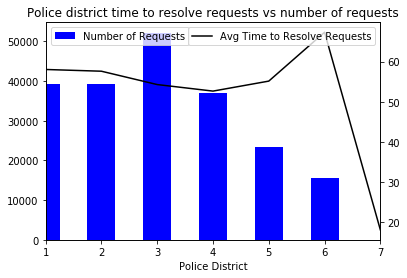

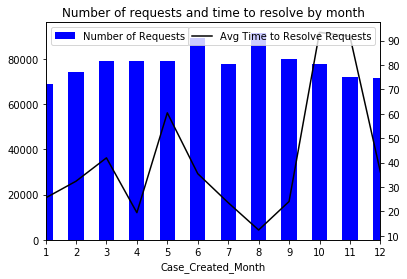

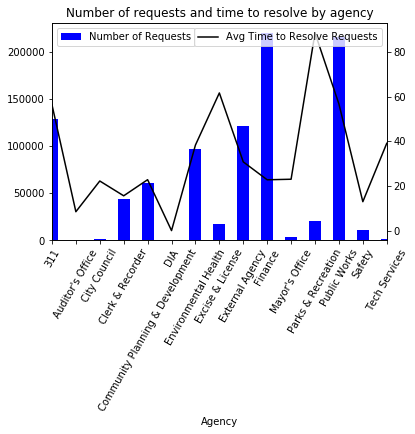

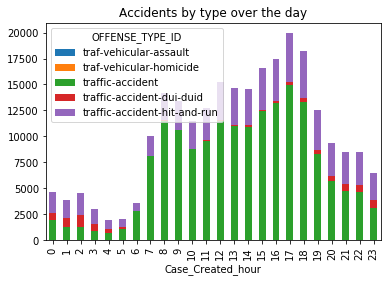

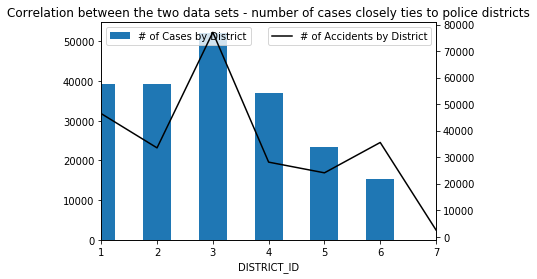

In [14]:
#Show police district data
ax = reporting_service_df.groupby(['Police District'])['count(Case Summary)'].sum().plot(kind = 'bar', color = 'b')
ax2 = reporting_service_df.groupby(['Police District'])['Time_To_Resolve_Requests_hour'].mean().plot(color = 'k', ax=ax, secondary_y=True)
ax.legend(['Number of Requests'],loc='upper left')
ax2.legend(['Avg Time to Resolve Requests'], loc='upper right')
ax.set_title('Police district time to resolve requests vs number of requests')
plt.show()

#Show request data by month 
ax = reporting_service_df.groupby('Case_Created_Month')['count(Case Summary)'].sum().reset_index().plot(x='Case_Created_Month', kind = 'bar', label = 'Count of Requests', color = 'b')
ax2 = reporting_service_df.groupby('Case_Created_Month')['Time_To_Resolve_Requests_hour'].mean().reset_index().plot(y='Time_To_Resolve_Requests_hour', linestyle='-', ax=ax,  secondary_y=True, color = 'k')
ax.legend(['Number of Requests'],loc='upper left')
ax2.legend(['Avg Time to Resolve Requests'], loc='upper right')
ax.set_title('Number of requests and time to resolve by month')
plt.show()

ax = reporting_service_df.groupby('Agency')['count(Case Summary)'].sum().reset_index().plot(x='Agency', kind = 'bar', label = 'Count of Requests', color = 'b')
ax2 = reporting_service_df.groupby('Agency')['Time_To_Resolve_Requests_hour'].mean().reset_index().plot(y='Time_To_Resolve_Requests_hour', linestyle='-', ax=ax,  secondary_y=True, color = 'k', rot=60)
ax.legend(['Number of Requests'],loc='upper left')
ax2.legend(['Avg Time to Resolve Requests'], loc='upper right')
ax.set_title('Number of requests and time to resolve by agency')
plt.show()

#The type of accident seems evenly distrubuted across months, in relation to total accidents
ax = reporting_accidents_df.groupby(['Case_Created_hour', 'OFFENSE_TYPE_ID'])['count(OFFENSE_TYPE_ID)'].sum().unstack().plot(kind = 'bar', stacked = True)
ax.set_title('Accidents by type over the day')
plt.show()

#Show correlation between two data sets
ax = reporting_service_df.groupby(['Police District'])['count(Case Summary)'].sum().plot(kind = 'bar', stacked = True)
ax2 = reporting_accidents_df.groupby(['DISTRICT_ID'])['count(OFFENSE_TYPE_ID)'].sum().plot(ax=ax, color = 'k', secondary_y=True)
ax.legend(['# of Cases by District'], loc = 'upper left')
ax2.legend(['# of Accidents by District'], loc='upper right')
ax.set_title('Correlation between the two data sets - number of cases closely ties to police districts')
plt.show()